## Overview

One of the fundamental characteristics of a clustering algorithm is that it's, for the most part, an unsurpervised learning process. Whereas traditional prediction and classification problems have a whole host of accuracy measures (RMSE, Entropy, Precision/Recall, etc), it might seem a little more abstract coming up with a comparable measure of "goodness of fit" for the way an unsupervised model aligns with our data.

Most introductory texts in the space (e.g. [this Medium post](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)) start by explaining a notion of an "Elbow method" that essentially a measure of class consistency. Essentially, you:

1. Break your data out into the classes that it was sorted into
2. Calculate the squared distance from each point to its centroid
3. Sum the squared errors

Something like this

In [1]:
import numpy as np

def wss_score(model, X):
    sse = 0
    centroids = model.cluster_centers_    

    for point in X.values:
        centroid = centroids[km.predict(point.reshape(1, -1))]
        sse += np.linalg.norm((centroid - point))
    
    return sse

This gives you the Within-Cluster Sum of Squared Error (WSS).

And in an overly-simple case like this, you'd fit various estimators at different values of `number_of_classes`. In this case, the author was trying different `k` values for her K-Means algorithm.

Inspecting the `k/Wss` chart below, there's a kink/elbow at the point `k=3`

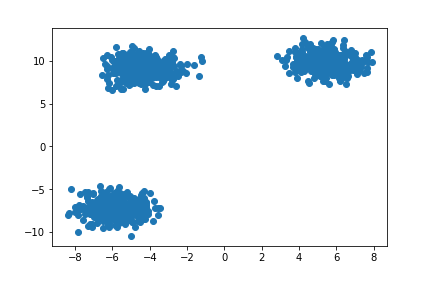

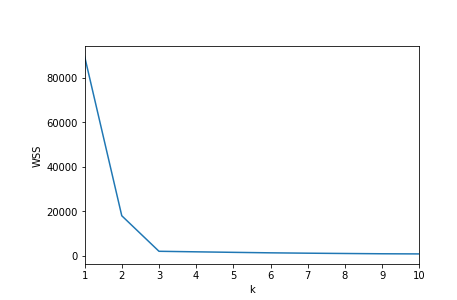

In [2]:
from IPython.display import Image
display(Image('images/3_classes.PNG'))
display(Image('images/elbow.PNG'))

However, as the post goes on to describe, the simplicity of this approach breaks down quickly when your data is less intentionally-generated.

### Silhouette

A popular alternative to the Elbow Method is using the Silhouette Coefficient.

Whereas the WSS only considers total in-class, "point-to-centroid" accuracy, the Silhouette also considers how well-separated classes are from one another. The [sklearn docs](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) do an excellent job explaining this, so I'm not going to try and compete.

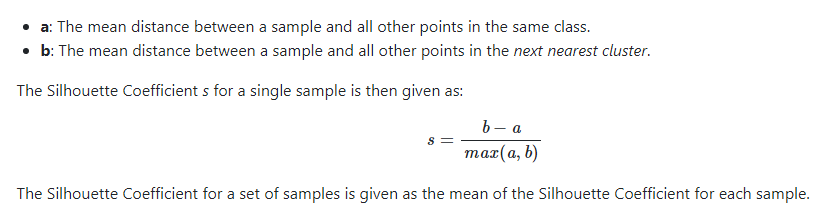

In [3]:
Image('images/silhouette.PNG')

Given a host of models, picking the one with the highest value of `s` means finding the class arrangement that simultaneously:

- maxing `b`: has the most cross-class separability
- mining `a`: has the tighest-packed centroids
- dividing by `max(a, b)`, normalizes the numerator by whatever we're good at, so we don't overly-value separability or centroid tightness

## On Data

Let's look at something a little less contrived.

In [4]:
%pylab inline

import pandas as pd
from sklearn.datasets import load_wine

data = load_wine()
wine = pd.DataFrame(data['data'], columns=data['feature_names'])

Populating the interactive namespace from numpy and matplotlib


Nevermind the context, if I told you to separate these data points into two classes, you'd probably draw a vertical line at the point `x=3.5`

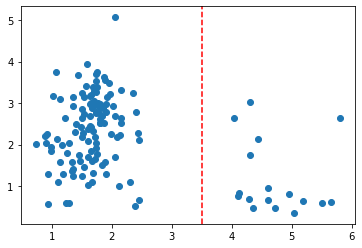

In [5]:
temp = wine[~((wine['malic_acid'] < 4)
               &
              (wine['malic_acid'] > 2.5 ))]

temp = temp[['malic_acid', 'flavanoids']]

plt.scatter(temp['malic_acid'], temp['flavanoids']);
plt.gca().axvline(3.5, c='r', ls='--');

If we iterate over potential values for `k` and plot the WSS curves, we can see an elbow at `k=3`

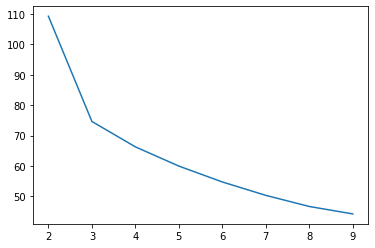

In [6]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots()

wss_scores = []
for k in range(2, 10):
    km = KMeans(k).fit(temp)
    
    wss_scores.append(wss_score(km, temp))
    
ax.plot(range(2, 10), wss_scores);

Plotting, this gives us a messy cluster on the left side where two classes just sort of bleed into one another, while the one on the right does its own thing.

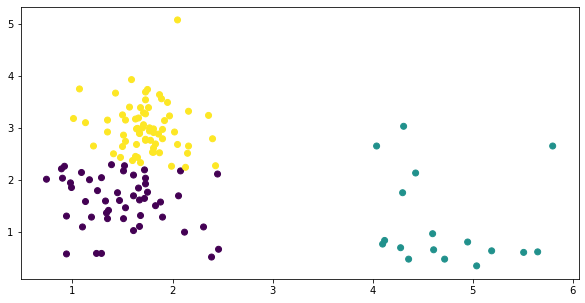

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

y = KMeans(3).fit_predict(temp)

plt.scatter(temp['malic_acid'], temp['flavanoids'],
            c=y);

On the other hand, recall that the silhouette score actively penalizes classes for being too close together, and thus a similar "plot the scores for various values of `k`" reveals the intuitive solution at `k=2`

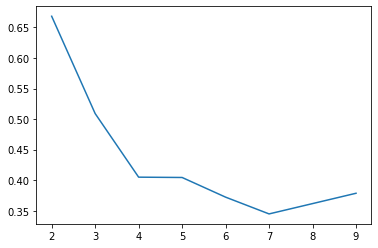

In [8]:
from sklearn.metrics import silhouette_score

silhouettes = []
for k in range(2, 10):
    km = KMeans(k).fit(temp)
    
    y = km.predict(temp)
    silhouettes.append(silhouette_score(temp, y))
    
fig, ax = plt.subplots()
ax.plot(range(2, 10), silhouettes);

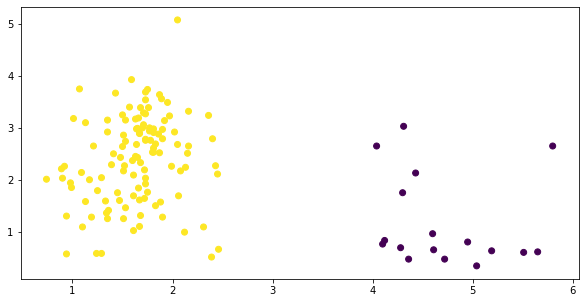

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

y = KMeans(2).fit_predict(temp)

plt.scatter(temp['malic_acid'], temp['flavanoids'],
            c=y);

### Less Nice

Okay, so that amounted to `k=2` vs `k=3`. Big deal, right?

Now look what happens when we take the bumper lanes off of our dataset.

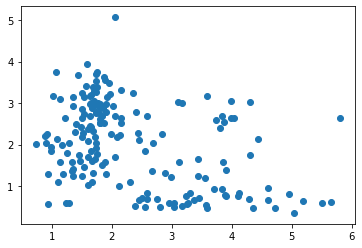

In [10]:
X = wine[['malic_acid', 'flavanoids']]

plt.scatter(*X.T.values);

Where did our neat elbow go? 4?

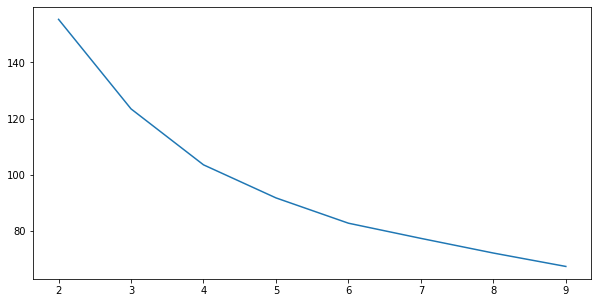

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

wss_scores = []
for k in range(2, 10):
    km = KMeans(k).fit(X)
    
    wss_scores.append(wss_score(km, X))
    
ax.plot(range(2, 10), wss_scores);

Well that's kind of a mess....

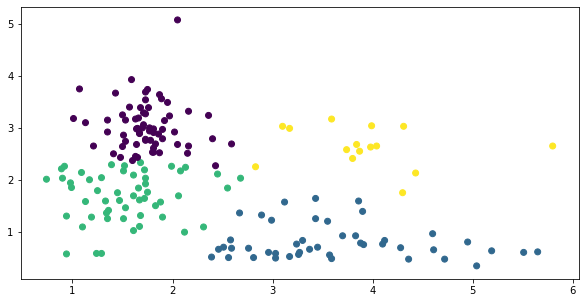

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

y = KMeans(4).fit_predict(X)

plt.scatter(X['malic_acid'], X['flavanoids'],
            c=y);

Same exercise, silhouette score sugggests we try `k=2` still

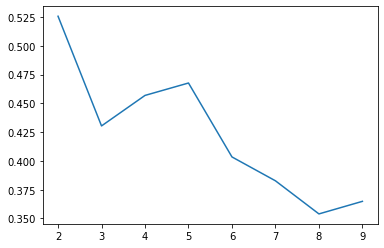

In [13]:
silhouettes = []
for k in range(2, 10):
    km = KMeans(k).fit(X)
    
    y = km.predict(X)
    silhouettes.append(silhouette_score(X, y))
    
fig, ax = plt.subplots()
ax.plot(range(2, 10), silhouettes);

Not bad, not bad.

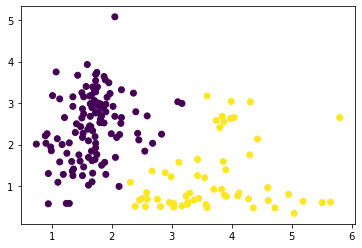

In [14]:
fig, ax = plt.subplots()

y = KMeans(2).fit_predict(X)

plt.scatter(X['malic_acid'], X['flavanoids'],
            c=y);

### Bad for Means

Now let's look at something a bit trickier. What about a situation where you'd draw a line more sophisticated than a vertical one?

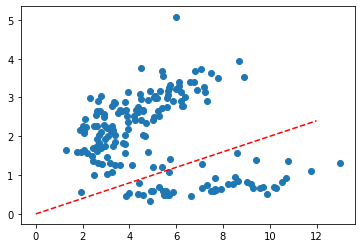

In [15]:
X = wine[['color_intensity', 'flavanoids']]

plt.scatter(*X.T.values);

trend_x = np.linspace(0, 12, 100)
trend_y = trend_x * .2

plt.plot(trend_x, trend_y, c='r', ls='--');

WSS gives us an elbow at `k=3`

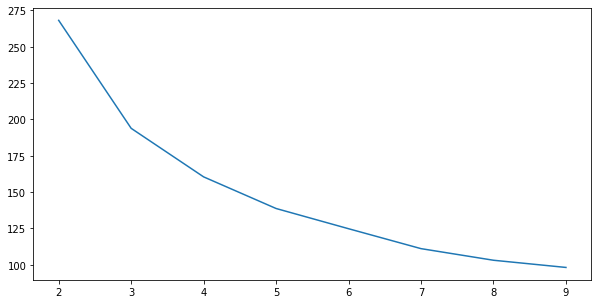

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

wss_scores = []
for k in range(2, 10):
    km = KMeans(k).fit(X)
    
    wss_scores.append(wss_score(km, X))
    
ax.plot(range(2, 10), wss_scores);

And fitting gives us three classes, placed clumsily next to one another, as if we *did* go the way of verical lines

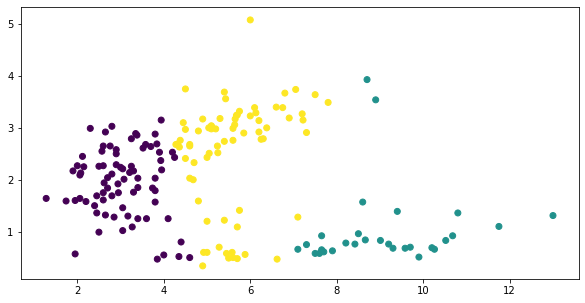

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

y = KMeans(3).fit_predict(X)

plt.scatter(*X.T.values,
            c=y);

Silhouette Score hasn't failed us yet

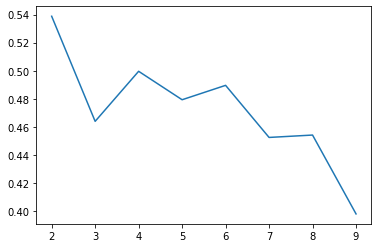

In [18]:
silhouettes = []
for k in range(2, 10):
    km = KMeans(k).fit(X)
    
    y = km.predict(X)
    silhouettes.append(silhouette_score(X, y))
    
fig, ax = plt.subplots()
ax.plot(range(2, 10), silhouettes);

Okay, this isn't much better....

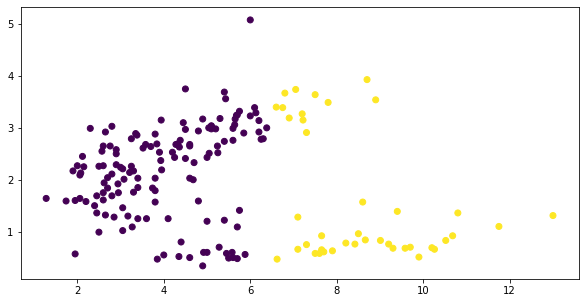

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

y = KMeans(2).fit_predict(X)

plt.scatter(*X.T.values,
            c=y);

Of course, our inability to arrive at a separation that we might have done visually lies more in the fact that we were using the wrong clustering algorithm, not the wrong measure.

Peeking at [this cheatsheet in the sklearn docs](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods), we decide to try a Gaussian Mixture Model.

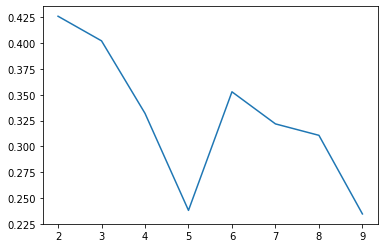

In [20]:
from sklearn.mixture import GaussianMixture

silhouettes = []
for k in range(2, 10):
    gm = GaussianMixture(k).fit(X)
    
    y = gm.predict(X)
    silhouettes.append(silhouette_score(X, y))
    
fig, ax = plt.subplots()
ax.plot(range(2, 10), silhouettes);

Our maximum silhouette score with `KMeans` was `.54`-- 25% higher than our max with `GaussianMixture`-- let's see if it's still usable...

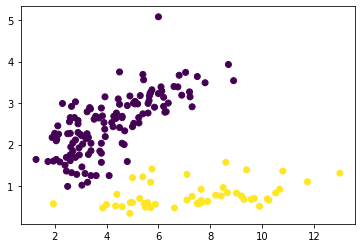

In [21]:
gm = GaussianMixture(n_components=2)

y = gm.fit_predict(X)

plt.scatter(*X.T.values, c=y);

God, this library is so dang cool.